# Computing Expected Product $\mathbb{E}[m\cdot n]$

$$
\boxed{
\mathbb{E}[m\cdot n] = \sum_{M=0}^{N} \mathbb{P}(M)
\sum_{p,q=0}^{M} 
\sum_{m,n=0}^{N}
T_d[m, p] \cdot T_d[n, q] \cdot 
\frac{Z_{K-2}(M - p - q)}{Z_K(M)} \cdot m n
}
$$

## 0. Modules

In [7]:
import numpy as np
from math import lgamma

## 1. Helper `logZ`

Work with logs throughout for numerical stability.

In [8]:
def logZ(k, n):
    return -np.inf if (n < 0 or k <= 0) else lgamma(n + k) - lgamma(k) - lgamma(n + 1)

## 2. Transition Matrix `T`

Initialize the matrix and fill it based on whether `K=2` (simple uniform case) or `K>2` (recursive computation of partitions).

Break down transition matrix combinatorics into cumulative sums by writing:
$$
\log Z_{K-1}(n) = \sum_{r=1}^{n} \log\left( \frac{r + K - 2}{r} \right)
$$
This allows to vectorize `T` column-wise instead of calling `lgamma` repeatedly
$$
$$

In [9]:
def transition_matrix(N, K):
    T = np.zeros((N + 1, N + 1))
    T[0, 0] = 1.0
    for j in range(1, N + 1):
        n = np.arange(j + 1)
        if K > 2:
            log_num = np.concatenate([[0.0], np.cumsum(np.log(n[1:] + K - 2) - np.log(n[1:]))])
        else:
            log_num = np.zeros(j + 1)
        T[j - n, j] = np.exp(log_num - logZ(K, j))
    return T

## 3. Distribution Propagators

Use matrix multiplication for vector $T^{\ell-1}\cdot \delta_N$ of ancestor probabilities $\mathbb{P}(M)$ and matrix power for $T_d = T^{L-\ell}$.

In [10]:
def propagators(N, T, ell, L):
    pM = np.zeros(N + 1)
    pM[N] = 1.0
    for _ in range(max(0, ell - 1)):
        pM = T @ pM
    T_d = np.linalg.matrix_power(T, max(0, L - ell))
    return pM, T_d

## 4. Computing the Joint Distribution

Now compute the (unnormalized) joint distribution of the pair `(m, n)` that we care about. 
We can use precomputed `logZ` functions for efficiency.

In [11]:
def joint_distribution(N, K, pM, T_d):
    # Denominators
    logZK = np.array([logZ(K, M) for M in range(N + 1)])
    km2 = K - 2
    # Numerators
    logZKm2 = np.array([
        0.0 if (km2 == 0 and r == 0) else logZ(km2, r)
        for r in range(N + 1)
    ])
    # Joint distribution
    P_tilde = np.zeros((N + 1, N + 1))
    # Loop over all possible ancestor chunk sizes
    for M, prob in enumerate(pM):
        # Skip if no zero chunk probability
        if prob == 0.0:
            continue
        # Transition matrix block for chunk size M
        Ts = T_d[:, :M + 1]
        # All possible chunk splits with p + q <= M
        p, q = np.ogrid[:M + 1, :M + 1]
        # Remaining mass for the third chunk broadcasted
        r = M - (p + q)
        # Interaction vertex parent to children
        U = np.exp(np.where(r >= 0, logZKm2[r] - logZK[M], -np.inf))
        # Einstein sum over all children splits
        P_tilde += prob * np.einsum('mp,nq,pq->mn', Ts, Ts, U, optimize=True)
    return P_tilde

## 5. Normalize

Normalize the joint distribution and compute the desired quantity

In [12]:
def compute_expectation(P_tilde):
    # Normalization
    Z = P_tilde.sum()
    if Z == 0.0:
        return 0.0
    # Expected 2-point function
    m = np.arange(P_tilde.shape[0])
    return np.einsum('ij,i,j->', P_tilde / Z, m, m)

## 6. Final Result

Final wrapper function in terms of parameters `N`, `K`, `L`, and `ell`.

In [13]:
def E_mn(N, K, L, ell):
    T = transition_matrix(N, K)
    v, T_d = propagators(N, T, ell, L)
    P_tilde = joint_distribution(N, K, v, T_d)
    return compute_expectation(P_tilde)

## 7. Plot

In [14]:
import matplotlib.pyplot as plt

def plot_E_mn_vs_ell(N, K, L):
    deltas = range(1, L)[::-1]
    E_vals = [E_mn(N, K, L, ell) for ell in range(1, L)]

    plt.figure(figsize=(7, 4))
    plt.plot(deltas, E_vals, marker='o')
    plt.yscale('log')
    plt.xlabel(r"$L - \ell$")
    plt.ylabel(r"$\mathbb{E}[m\,n]$")
    plt.title(f"N={N}, K={K}, L={L}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


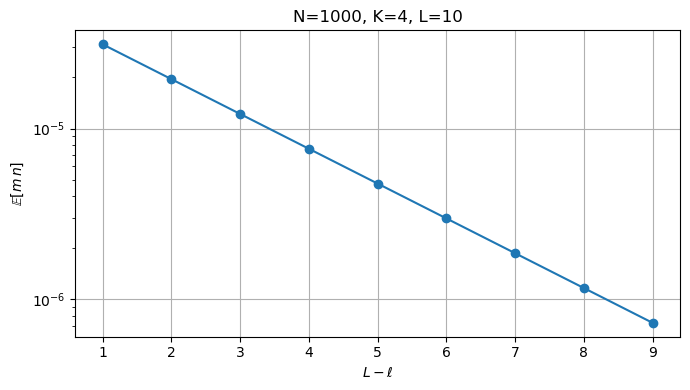

In [42]:
plot_E_mn_vs_ell(N=1000, K=4, L=10)

## 8. Theory

$$
\boxed{
\mathbb{E}[m\,n] = \frac{2^{\ell - 1} \, N(N - 1)}{K^{2L - \ell} (K + 1)^{\ell}}
}
$$


In [15]:
def theory_E_mn(N, K, L, ell):
    return (2**(ell - 1) * N * (N - 1)) / (K**(2 * L - ell) * (K + 1)**ell)

In [16]:
def plot_computed_vs_theory(N, K, L):
    deltas = range(1, L)[::-1]
    E_vals_computed = [E_mn(N, K, L, ell) for ell in range(1, L)]
    E_vals_theory   = [theory_E_mn(N, K, L, ell) for ell in range(1, L)]

    plt.figure(figsize=(7, 4))
    plt.plot(deltas, E_vals_computed, marker='o', label="Computed")
    plt.plot(deltas, E_vals_theory, marker='s', linestyle='--', label="Theory")
    plt.yscale('log')
    plt.xlabel(r"$L - \ell$")
    plt.ylabel(r"$\mathbb{E}[m\,n]$")
    plt.title(f"N={N}, K={K}, L={L}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


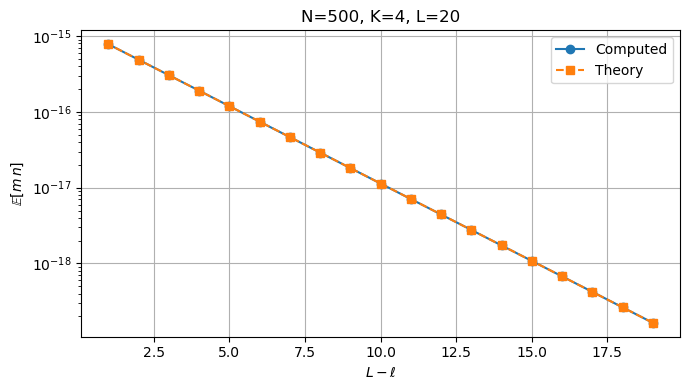

In [17]:
plot_computed_vs_theory(N=500, K=4, L=20)

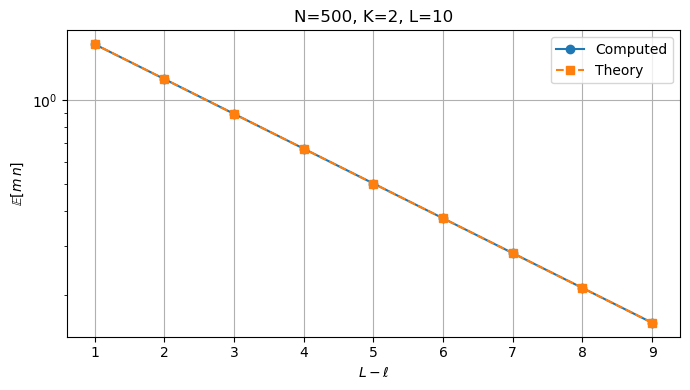

In [18]:
plot_computed_vs_theory(N=500, K=2, L=10)